In [1]:
from model import SugarscapeCg
from agents import Cop, Criminal

from IPython.display import clear_output
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner, BatchRunnerMP

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime

## Helper functions

In [2]:
def run_model(model):
    model.run_model()

    output = model.datacollector.get_model_vars_dataframe()
    print(output)

    return output

In [3]:
def get_data(df, key):
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [4]:
def get_means_cis(data):
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

In [5]:
def get_average_crime_per_distr(outputs, district_names, burn_in):
    avg_crimes_per_distr_dict = {'Centrum': 0, 'Nieuw-West': 0, 'Noord': 0, 'Oost': 0, 'West': 0, 'Zuid': 0, 'Zuidoost': 0} 
    for i in range(len(outputs)):
        for district in district_names:
            avg_crimes_per_distr_dict[district] += np.mean(outputs[i].iloc[burn_in:][district])
    for district in district_names:
        avg_crimes_per_distr_dict[district] /= len(outputs)
    return dict(sorted(avg_crimes_per_distr_dict.items(), key=lambda item:item[1]))

## Plotting functions

In [6]:
def plot_errorbars(means, cis, y_axis_label):
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [7]:
def plot_district_crimes(district_means, district_cis, district_names, district_colors):
    for district_index in range(len(district_means)):
        plt.errorbar(x=range(len(district_means[district_index])), y=district_means[district_index], yerr=district_cis[district_index], label=district_names[district_index], color=district_colors[district_index], ecolor=district_colors[district_index])
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [8]:
# def plot_district_crimes_bar(district_means, district_cis, district_names, district_colors):
#     plt.bar(np.arange(len(district_means)), height=district_means, yerr=district_cis, color=district_colors, capsize=10)
#     plt.xticks(np.arange(len(district_means)), district_names)
#     # plt.xlabel("Number of steps")
#     plt.ylabel('Number of crimes')

In [9]:
def plot_district_means_bar(avg_crimes_per_distr_dict, district_colors):
    plt.bar(avg_crimes_per_distr_dict.keys(), avg_crimes_per_distr_dict.values(), color=district_colors)
    plt.legend()
    plt.show()
    return

In [10]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    indices = s['S' + i]
    errors = s['S' + i + '_conf']
    plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Sensitivity Analysis

In [11]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'],
    'bounds': [[0, 20], [1, 10], [1, 10], [0, 500], [0, 100]]
}

# Set the outputs
model_reporters = {
    "Total crimes": lambda m: m.schedule.get_crimes_commited(), 
    "Criminals in jail": lambda m: m.schedule.get_criminal_count_in_jail(),
    # "Centrum": lambda m: m.get_crimes_per_district()['Centrum'],
    # "Noord": lambda m: m.get_crimes_per_district()['Noord'],
    # "West": lambda m: m.get_crimes_per_district()['West'],
    # "Zuid": lambda m: m.get_crimes_per_district()['Zuid'],
    # "Zuidoost": lambda m: m.get_crimes_per_district()['Zuidoost'],
    # "Oost": lambda m: m.get_crimes_per_district()['Oost'],
    # "Nieuw-West": lambda m: m.get_crimes_per_district()['Nieuw-West'],
    "Centrum": lambda m:m.schedule.update_average_crimes_per_timestep("Centrum").get("Centrum"),
    "Noord": lambda m:m.schedule.update_average_crimes_per_timestep("Noord").get("Noord"),
    "West": lambda m:m.schedule.update_average_crimes_per_timestep("West").get("West"),
    "Zuid": lambda m:m.schedule.update_average_crimes_per_timestep("Zuid").get("Zuid"),
    "Zuidoost": lambda m:m.schedule.update_average_crimes_per_timestep("Zuidoost").get("Zuidoost"),
    "Oost": lambda m:m.schedule.update_average_crimes_per_timestep("Oost").get("Oost"),
    "Nieuw-West": lambda m:m.schedule.update_average_crimes_per_timestep("Nieuw-West").get("Nieuw-West")
}
# model_reporters = {"Data Collector": lambda m: m.datacollector},

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 1#10
max_steps = 300#200
distinct_samples = 500#500

param_values = saltelli.sample(problem, N=distinct_samples, calc_second_order=False)

batch = BatchRunner(SugarscapeCg, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (500) is equal to `2^n`.
        
  warnings.warn(msg)


In [12]:
count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'])
data['Run'], data['Centrum'], data['Criminals in jail'] = None, None, None
data['Nieuw-West'], data['Noord'], data['Oost'], data['Total crimes'], data['West'], data['Zuid'], data['Zuidoost'] = None, None, None, None, None, None, None

# print(data)

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals = [int(item) for item in vals]
        # print(vals)
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        # print(variable_parameters)

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = int(count) # Don't know what causes this, but iteration number is not correctly filled
        # print(iteration_data)

        data.iloc[count, :len(problem['names'])] = vals  # fills in varied parameter
        data.iloc[count, len(problem['names']):] = iteration_data  # fills in output data
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [13]:
print(data)

ct = datetime.datetime.now()
filename = 'sensitivity_analysis_output_' + str(ct)
data.to_csv(filename)

     jail_sentence criminal_risk_radius cop_catch_radius  \
0                0                    3                9   
1               11                    3                9   
2                0                    6                9   
3                0                    3                9   
4                0                    3                9   
...            ...                  ...              ...   
3495             6                    2                8   
3496             6                    9                6   
3497             6                    9                8   
3498             6                    9                8   
3499             0                    2                6   

     criminal_risk_aversion criminal_disconnectivity     Run   Centrum  \
0                       495                       45     0.0     5.393   
1                       495                       45     1.0    1.3831   
2                       495                       45     

In [14]:
Si_crimes = sobol.analyze(problem, data['Total crimes'].values, calc_second_order=False, print_to_console=True)
Si_jail = sobol.analyze(problem, data['Criminals in jail'].values, calc_second_order=False, print_to_console=True)
Si_centrum = sobol.analyze(problem, data['Centrum'].values, calc_second_order=False, print_to_console=True)
Si_noord = sobol.analyze(problem, data['Noord'].values, calc_second_order=False, print_to_console=True)
Si_west = sobol.analyze(problem, data['West'].values, calc_second_order=False, print_to_console=True)
Si_zuid = sobol.analyze(problem, data['Zuid'].values, calc_second_order=False, print_to_console=True)
Si_zuidoost = sobol.analyze(problem, data['Zuidoost'].values, calc_second_order=False, print_to_console=True)
Si_oost = sobol.analyze(problem, data['Oost'].values, calc_second_order=False, print_to_console=True)
Si_nieuw_west = sobol.analyze(problem, data['Nieuw-West'].values, calc_second_order=False, print_to_console=True)

                                ST   ST_conf
jail_sentence             0.789608  0.104999
criminal_risk_radius      0.962001  0.115239
cop_catch_radius          0.918273  0.110476
criminal_risk_aversion    0.921759  0.126561
criminal_disconnectivity  0.910356  0.109431
                                S1   S1_conf
jail_sentence             0.033346  0.124200
criminal_risk_radius     -0.106844  0.132337
cop_catch_radius         -0.061168  0.139340
criminal_risk_aversion   -0.039814  0.118849
criminal_disconnectivity  0.077515  0.105119
                                ST   ST_conf
jail_sentence             0.803806  0.087107
criminal_risk_radius      0.922760  0.106840
cop_catch_radius          0.907821  0.095496
criminal_risk_aversion    0.927909  0.095548
criminal_disconnectivity  0.860440  0.100743
                                S1   S1_conf
jail_sentence             0.068992  0.112845
criminal_risk_radius     -0.089355  0.136780
cop_catch_radius         -0.025334  0.125148
criminal_r

{'S1': array([ 0.03334572, -0.10684363, -0.06116805, -0.03981367,  0.07751536]), 'S1_conf': array([0.12420049, 0.13233678, 0.13934033, 0.11884928, 0.10511936]), 'ST': array([0.78960763, 0.96200128, 0.9182729 , 0.92175857, 0.91035617]), 'ST_conf': array([0.10499928, 0.11523943, 0.11047602, 0.12656126, 0.10943078])}


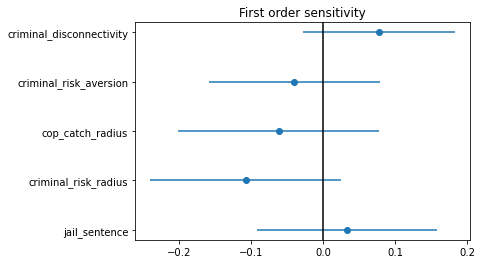

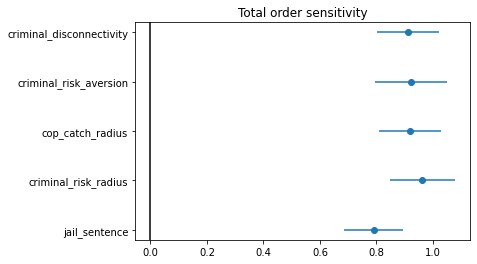

{'S1': array([ 0.06899163, -0.08935465, -0.02533392,  0.01224366,  0.05321363]), 'S1_conf': array([0.11284544, 0.13678046, 0.12514843, 0.13445037, 0.12500312]), 'ST': array([0.8038055 , 0.92275973, 0.90782124, 0.92790945, 0.86044012]), 'ST_conf': array([0.08710654, 0.10684042, 0.09549622, 0.09554776, 0.10074336])}


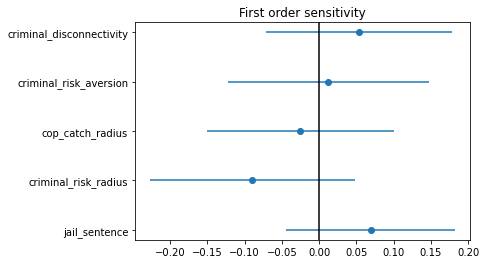

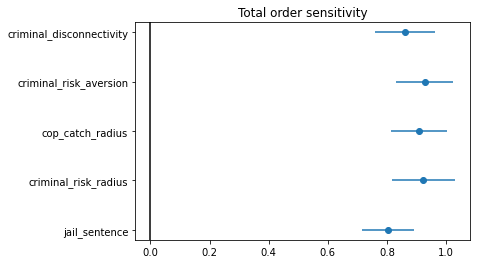

{'S1': array([-0.00488911, -0.04420735, -0.06365395, -0.00895517,  0.08703626]), 'S1_conf': array([0.14555047, 0.13370448, 0.13070329, 0.12564391, 0.117355  ]), 'ST': array([1.18755429, 1.12579208, 1.04993956, 1.01114768, 1.15051002]), 'ST_conf': array([0.33106992, 0.27328328, 0.18196965, 0.20789205, 0.20287741])}


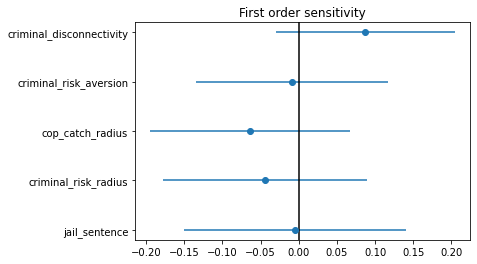

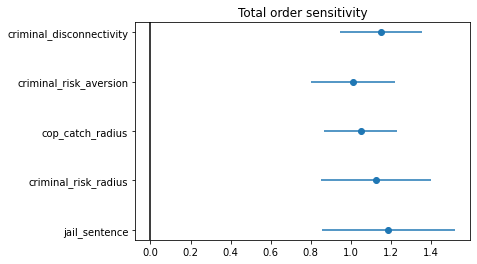

{'S1': array([ 0.01742213, -0.05825012, -0.02749799,  0.00650349,  0.08802349]), 'S1_conf': array([0.11345553, 0.17766282, 0.15182318, 0.16426834, 0.18339714]), 'ST': array([0.86517766, 1.0831651 , 0.99165401, 1.06109078, 0.9728167 ]), 'ST_conf': array([0.14548236, 0.16808632, 0.18063224, 0.18134112, 0.13396839])}


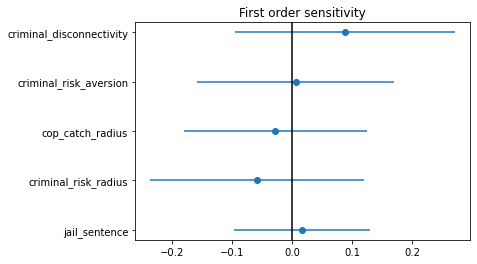

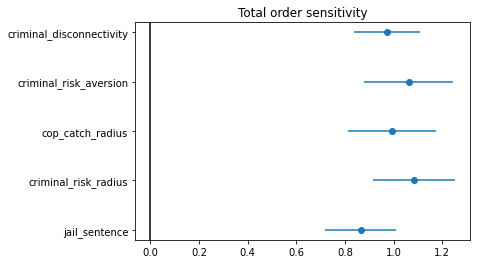

{'S1': array([-0.0085263 , -0.09601589, -0.05800433, -0.03997404,  0.12694606]), 'S1_conf': array([0.14309774, 0.15004752, 0.13446789, 0.14859991, 0.16130754]), 'ST': array([0.83927508, 0.95589238, 0.90026713, 0.96396319, 0.92266186]), 'ST_conf': array([0.1649846 , 0.19427008, 0.16079949, 0.15203348, 0.14939775])}


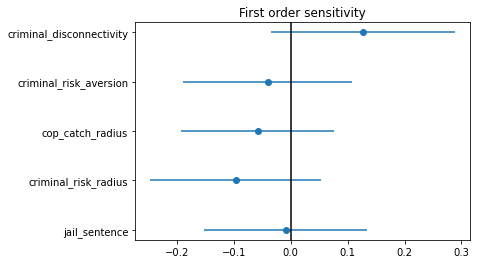

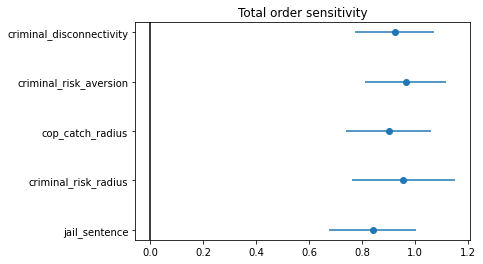

{'S1': array([ 0.07677836, -0.00323202, -0.03437539, -0.01169153,  0.09295283]), 'S1_conf': array([0.12120374, 0.13779291, 0.11965354, 0.12530003, 0.11511938]), 'ST': array([0.86755652, 1.09451316, 0.98558616, 0.99740252, 1.01692546]), 'ST_conf': array([0.11909036, 0.13407023, 0.13345439, 0.12205671, 0.11077707])}


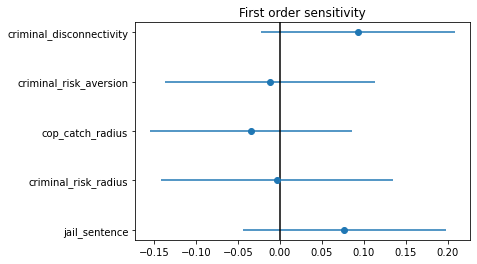

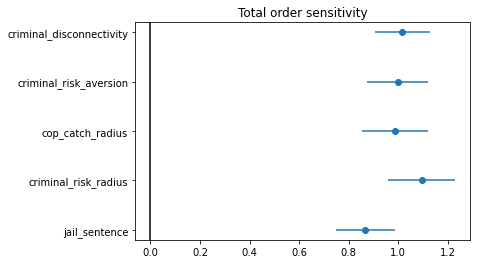

{'S1': array([ 0.08207663, -0.07687476, -0.08547993, -0.02813313,  0.06752045]), 'S1_conf': array([0.10970187, 0.13462934, 0.12411289, 0.12657281, 0.13200555]), 'ST': array([0.7550346 , 0.89828091, 0.81483218, 0.84626193, 0.97377395]), 'ST_conf': array([0.1035404 , 0.1356971 , 0.13097119, 0.13628283, 0.13351872])}


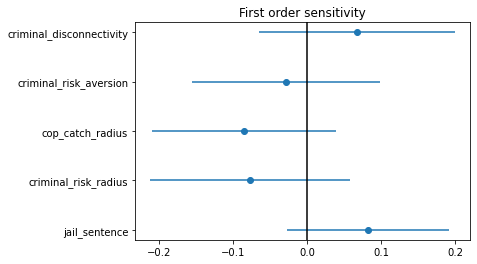

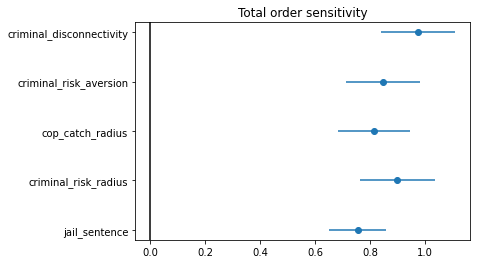

{'S1': array([-0.01640706, -0.08341603, -0.06588232, -0.05194623, -0.02115808]), 'S1_conf': array([0.10934741, 0.13282815, 0.11694204, 0.12935   , 0.12243977]), 'ST': array([0.81490775, 0.96257852, 0.79776278, 0.92778914, 0.83410038]), 'ST_conf': array([0.1469493 , 0.14916726, 0.11105041, 0.14973507, 0.13536924])}


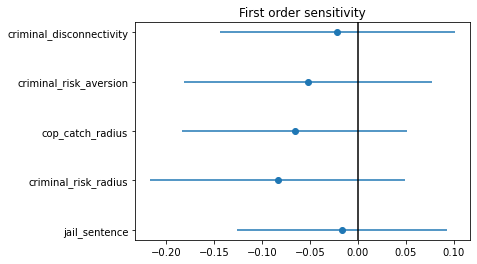

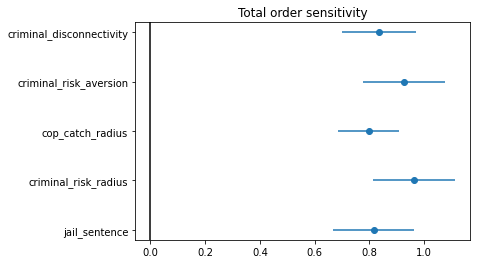

{'S1': array([ 0.08153535, -0.05707166,  0.00834519,  0.05811444,  0.08150826]), 'S1_conf': array([0.12697282, 0.12943071, 0.12162837, 0.11490982, 0.12464807]), 'ST': array([0.83691723, 0.9457283 , 0.90762788, 0.89402856, 0.87883195]), 'ST_conf': array([0.10673145, 0.10963115, 0.10702447, 0.1041499 , 0.09965461])}


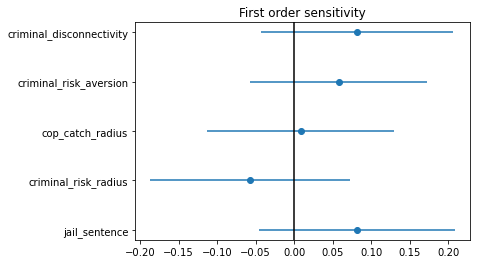

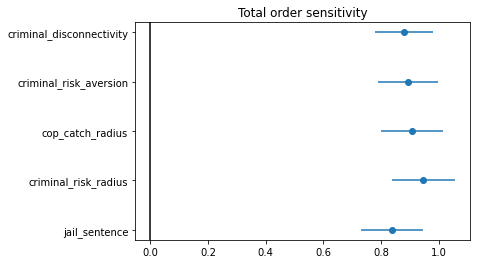

In [15]:
for Si in (Si_crimes, Si_jail, Si_centrum, Si_noord, Si_west, Si_zuid, Si_zuidoost, Si_oost, Si_nieuw_west):
    print(Si)

    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # # Second order
    # plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    # plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

# Run model

In [16]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

In [17]:
num_runs = 2
outputs = []

for run in range(num_runs):
    m = SugarscapeCg(criminal_risk_radius=5, cop_catch_radius=1)
    print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
    output = run_model(m)
    outputs.append(output)

Search radius for criminal is :5 
 Catch radius is :1
     Criminal Wealth  Criminal Count  Criminal in Jail Count  Crimes commited  \
0              603.0              45                       0                0   
1              327.0              45                       0               17   
2              261.0              45                       0               40   
3              -14.0              45                       0               57   
4             -405.0              45                       0               72   
..               ...             ...                     ...              ...   
196          10633.0              45                       2             4818   
197          10878.0              45                       2             4849   
198          11084.0              45                       1             4878   
199          11413.0              45                       0             4911   
200          11670.0              45                   

In [18]:
print(np.mean(outputs[1]["Zuid"]), np.mean(outputs[1]["Centrum"]))

4.497512437810945 1.0945273631840795


## Plots

### Criminal wealths

In [19]:
all_wealths = get_data(outputs, 'Criminal Wealth')

# print(all_wealths[0])
print(all_wealths.shape)

(201, 2)


In [20]:
mean_wealths, cis_wealths = get_means_cis(all_wealths)

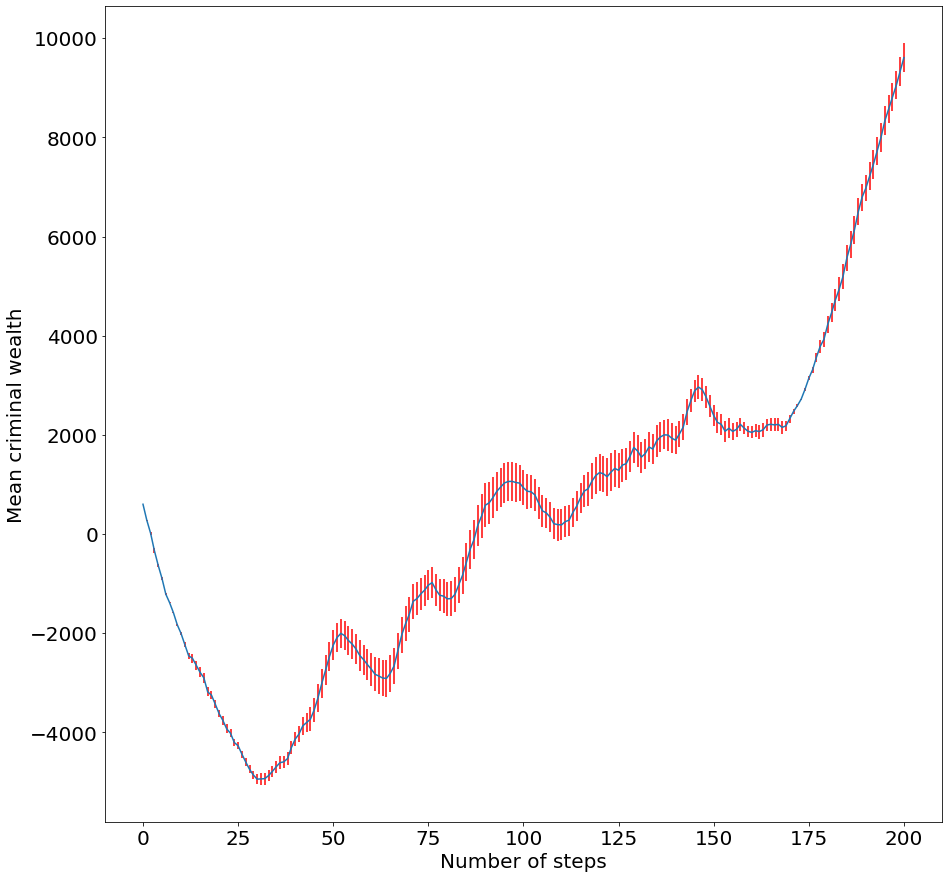

In [21]:
plot_errorbars(mean_wealths, cis_wealths, "Mean criminal wealth")

### Criminals in jail

In [22]:
jail_count = get_data(outputs, 'Criminal in Jail Count')

print(jail_count.shape)

(201, 2)


In [23]:
mean_jail_count, cis_jail_count = get_means_cis(jail_count)

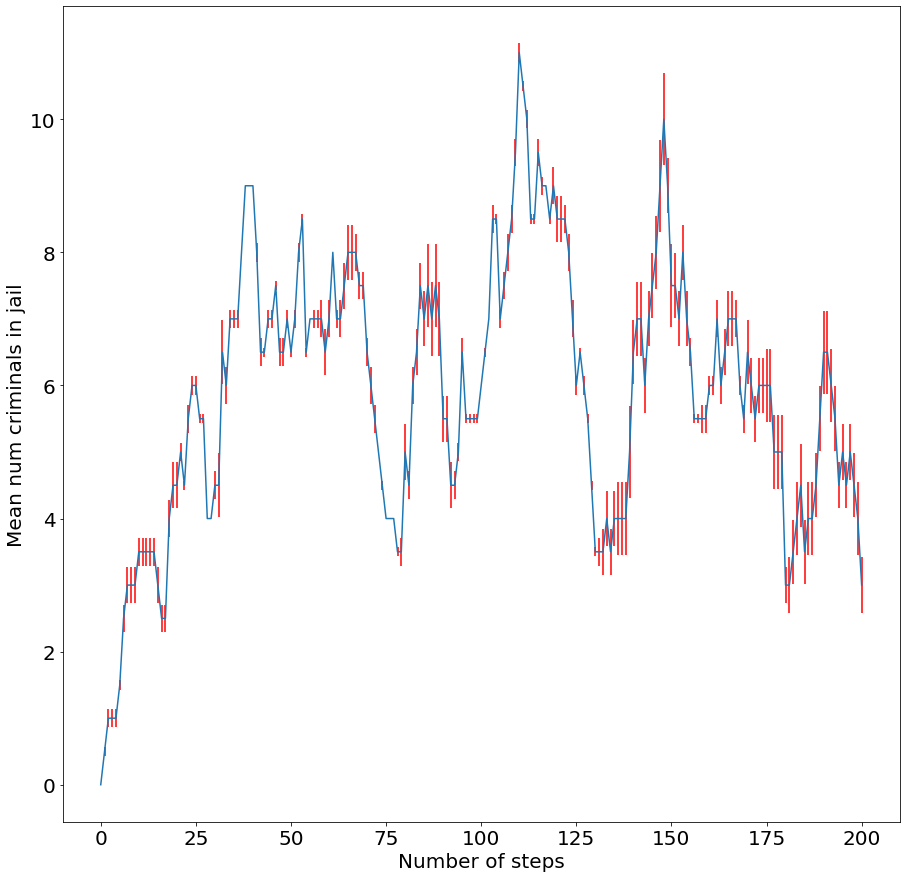

In [24]:
plot_errorbars(mean_jail_count, cis_jail_count, "Mean num criminals in jail")

### Crimes committed

In [25]:
crimes_count = get_data(outputs, 'Crimes commited')

print(crimes_count.shape)

(201, 2)


In [26]:
mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)

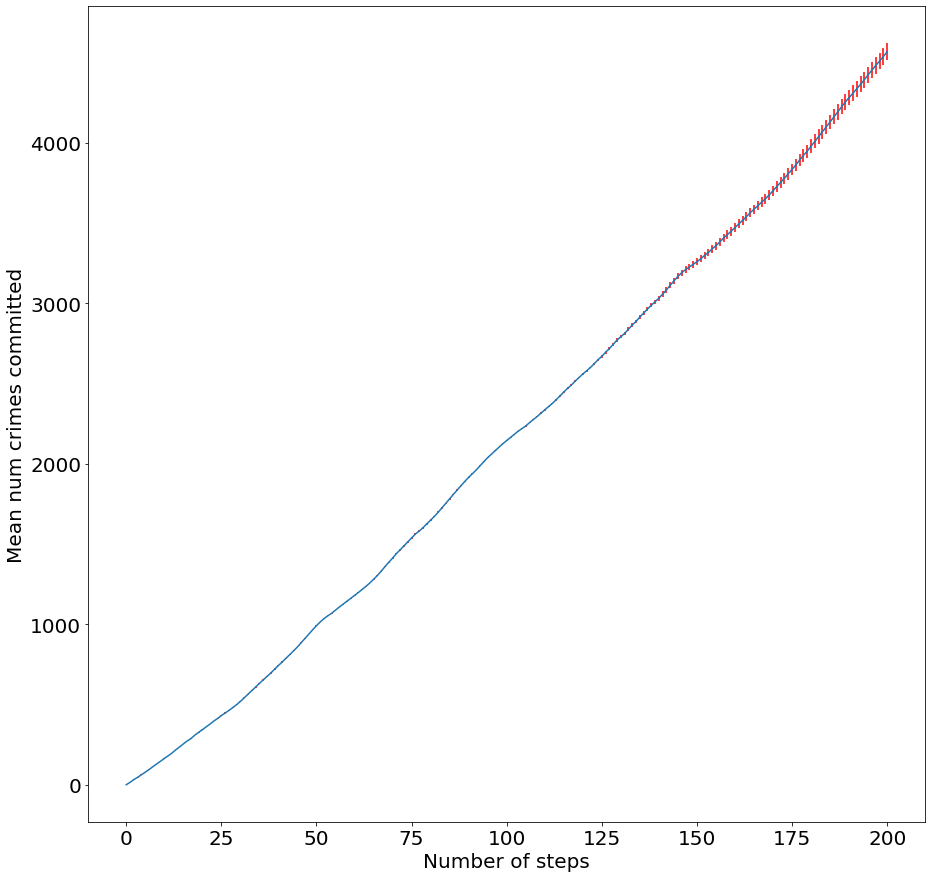

In [27]:
plot_errorbars(mean_crimes_count, cis_crimes_count, "Mean num crimes committed")

### District crimes

No handles with labels found to put in legend.


Centrum
Zuidoost
West
Oost
Noord
Zuid
Nieuw-West


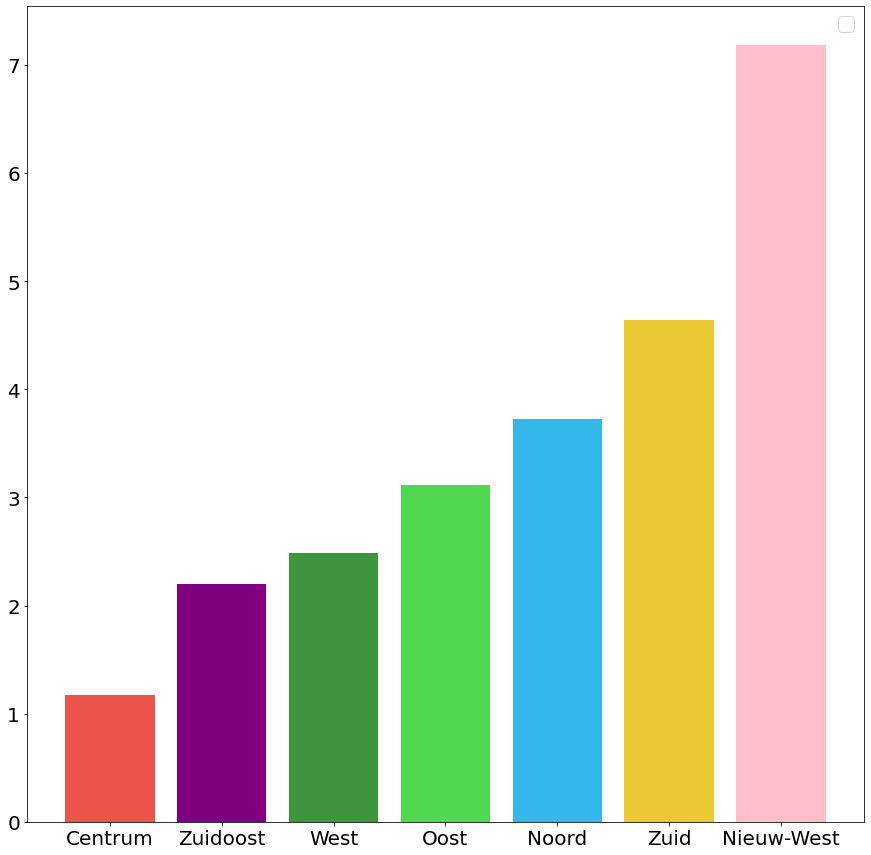

In [28]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

avg_crimes_per_distr_dict = get_average_crime_per_distr(outputs, district_names, 100)

# Sort colors
district_colors = []
for district in avg_crimes_per_distr_dict.keys():
    print(district)
    for dictionary in districts_dict:
        if dictionary['Label'] == district:
            district_colors.append(dictionary['Color'])

plot_district_means_bar(avg_crimes_per_distr_dict, district_colors)

In [29]:
all_district_means = []
all_district_cis = []

for district in district_names:
    crimes_count = get_data(outputs, district)
    mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)
    all_district_means.append(mean_crimes_count)
    all_district_cis.append(cis_crimes_count)

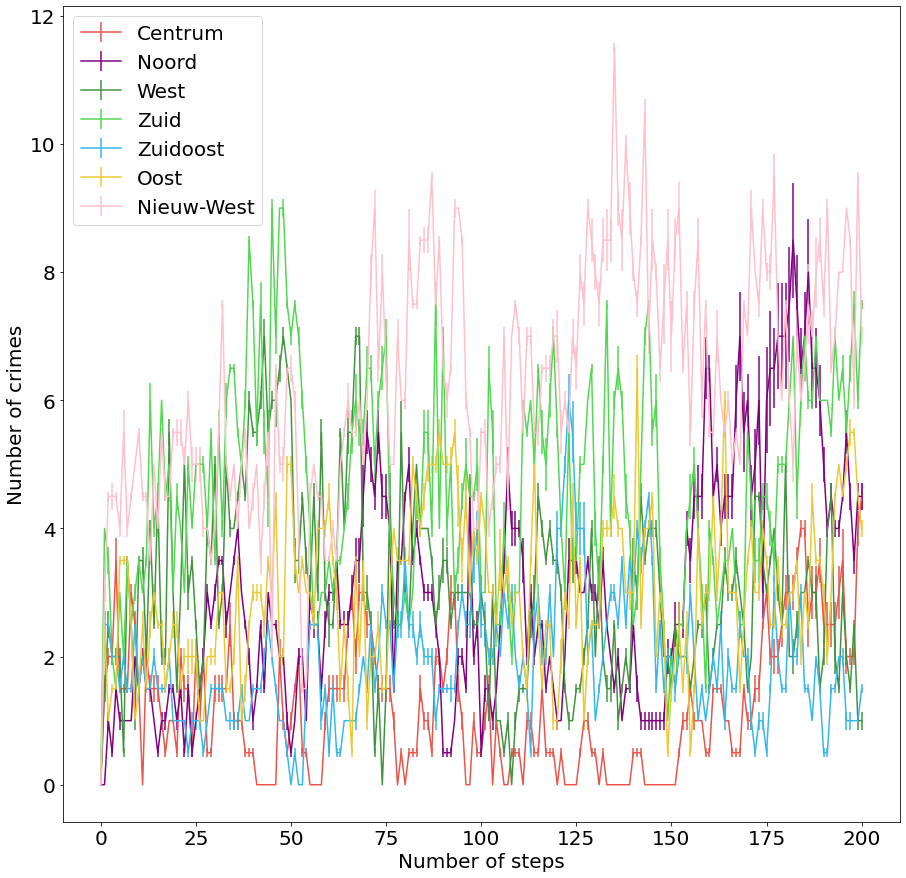

In [30]:
plot_district_crimes(all_district_means, all_district_cis, district_names, district_colors)

In [31]:
# print(len(all_district_means))
# print(len(all_district_means[0]))

# final_district_means = []
# for district in all_district_means:
#     final_district_means.append(district[-1])

# print(final_district_means)

# final_district_cis = []
# for district in all_district_cis:
#     final_district_cis.append(district[-1])

# print(final_district_cis)

In [32]:
# # Sort by size
# sorting = zip(final_district_means, district_names, district_colors)
# final_district_means, district_names, district_colors = zip(*sorted(sorting, key=lambda x : x[0]))

In [33]:
# plot_district_crimes_bar(final_district_means, final_district_cis, district_names, district_colors)